In [1]:
DATA_CSV = "/Users/ugyen/Documents/GitHub/Stockex-btn/Dataset/BTCL.csv"
FUTURE_ACTUAL_CSV = "/Users/ugyen/Documents/GitHub/Stockex-btn/Ensemble/BTCL_future_actual_cleaned.csv"
METRICS_OUT = "/Users/ugyen/Documents/GitHub/Stockex-btn/btcl_model_metrics.csv"
COMPARE_OUT = "/Users/ugyen/Documents/GitHub/Stockex-btn/btcl_actual_vs_predictions.csv"
FORECAST_HORIZON = 30  # days
LSTM_WINDOW = 60
LSTM_EPOCHS = 50
LSTM_BATCH = 32
SMOOTH_WINDOW = 3      # for simple signal smoothing (moving average)
SIGNAL_THRESHOLD = 0.0 # change threshold for signal flip (0 = any change)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import plotly.graph_objects as go

# ML + Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Time Series
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


2025-08-28 11:50:22.800694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def check_stationarity(series):
    series = series.dropna()
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.6f}")
    return result[1] < 0.05


def evaluate(y_true, y_pred):
    return {
        'RMSE': float(np.sqrt(mean_squared_error(y_true, y_pred))),
        'MAE' : float(mean_absolute_error(y_true, y_pred)),
        'R2'  : float(r2_score(y_true, y_pred))
    }


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    X = np.array(X)
    y = np.array(y)
    # reshape to [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


def safe_reindex_align(df_to_align, index_ref, col_name=None):
    df = df_to_align.copy()
    df = df.reindex(index_ref)
    if col_name and col_name in df.columns:
        return df[col_name].dropna()
    return df.dropna()


✅ Loaded daily series:
             BTCL
DateTime         
2025-04-21  570.0
2025-04-22  570.0
2025-04-23  570.0
2025-04-24  570.0
2025-04-25  570.0


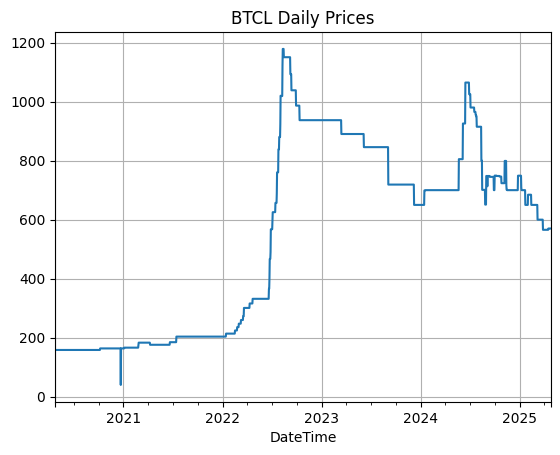

11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:54 - cmdstanpy - INFO - Chain [1] done processing



📏 Stationarity check (ADF) on BTCL:
ADF Statistic: -1.7295
p-value: 0.415986
Selected ARIMA order: (2, 1, 3)
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 0.0561 - val_loss: 0.0018
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 8.4168e-04 - val_loss: 0.0013
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 4.6284e-04 - val_loss: 0.0018
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 7.3071e-04 - val_loss: 0.0012
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 3.9288e-04 - val_loss: 0.0012
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 3.6097e-04 - val_loss: 0.0011
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 3.8908e-04 - val_loss: 9.9562e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 3.2629e-04 - val_loss: 0.0012
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 2.7235e-04 - val_loss: 9.6898e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 2.2195e-04 - v


✅ Model Performance on Future Data:
                RMSE        MAE        R2
Prophet   57.196718  50.804114 -1.784544
ARIMA     41.711272  24.253246 -0.480876
LSTM      43.293949  26.237952 -0.595388
Ensemble  34.257061  29.965633  0.001123

📊 Actual vs Forecasted Prices (First 10 Rows):
            Actual Price     Prophet       ARIMA        LSTM    Ensemble
2025-04-28         570.0  629.815493  569.780545  568.784851  589.460296
2025-04-29         570.0  630.367080  569.709543  568.495972  589.524198
2025-04-30         570.0  632.600526  569.649219  568.204407  590.151384
2025-05-01         570.0  633.191850  569.584575  567.925964  590.234130
2025-05-05         570.0  635.363372  569.362162  567.047913  590.591149
2025-05-06         650.0  635.954430  569.313010  566.889404  590.718948
2025-05-08         647.5  638.728242  569.217710  566.607666  591.517873
2025-05-09         647.5  639.837749  569.172119  566.492737  591.834202
2025-05-12         647.5  640.182936  569.048451  56


📌 Buy/Sell Signals (head):
              Ensemble  Ensemble_SMA  Signal         Buy        Sell
2025-04-26  589.645055    589.645055      -1         NaN  589.645055
2025-04-27  589.698482    589.671769       1  589.698482         NaN
2025-04-28  589.460296    589.601278      -1         NaN  589.460296
2025-04-29  589.524198    589.560992      -1         NaN  589.524198
2025-04-30  590.151384    589.711959       1  590.151384         NaN
2025-05-01  590.234130    589.969904       1  590.234130         NaN
2025-05-02  590.532170    590.305895       1  590.532170         NaN
2025-05-03  590.682391    590.482897       1  590.682391         NaN
2025-05-04  590.774459    590.663007       1  590.774459         NaN
2025-05-05  590.591149    590.682666       1  590.591149         NaN



💰 Final ROI: 0.20% on initial capital of 100000

📊 Trade Log (head):
        Date Action       Price    Profit       ROI
0 2025-04-27    Buy  589.698482       NaN       NaN
1 2025-04-28   Sell  589.460296 -0.238186 -0.000404
2 2025-04-30    Buy  590.151384       NaN       NaN
3 2025-05-12   Sell  591.816651  1.665267  0.002822
4 2025-05-14    Buy  592.460120       NaN       NaN

📆 Forecast Duration: 29 days (~0.08 years)


In [4]:
if __name__ == "__main__":
    # 1) Load & pre-process
    df = pd.read_csv(DATA_CSV)
    if 'DateTime' not in df.columns or 'BTCL' not in df.columns:
        raise ValueError("CSV must contain 'DateTime' and 'BTCL' columns.")

    # Normalize/clean dates
    df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date
    daily_df = df.groupby('DateTime').last().reset_index()
    daily_df['DateTime'] = pd.to_datetime(daily_df['DateTime'])
    daily_df = daily_df.set_index('DateTime').sort_index()

    # Ensure daily frequency, forward-fill gaps
    daily_df = daily_df.asfreq('D')
    daily_df['BTCL'] = daily_df['BTCL'].ffill()

    print("\n Loaded daily series:")
    print(daily_df.tail())

    # Optional quick plot (matplotlib)
    try:
        daily_df['BTCL'].plot(title='BTCL Daily Prices')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"(Plot skipped) {e}")

    last_hist_date = daily_df.index.max()
    forecast_index = pd.date_range(start=last_hist_date + timedelta(days=1), periods=FORECAST_HORIZON, freq='D')

    # 2) Prophet
    prophet_df = daily_df.reset_index().rename(columns={'DateTime': 'ds', 'BTCL': 'y'})
    prophet = Prophet(daily_seasonality=True)
    prophet.fit(prophet_df)

    future = prophet.make_future_dataframe(periods=FORECAST_HORIZON)
    prophet_forecast = prophet.predict(future)

    # Slice Prophet to only the future horizon
    prophet_result = (
        prophet_forecast[['ds', 'yhat']]
        .set_index('ds')
        .rename(columns={'yhat': 'Prophet'})
    )
    # Align to our future forecast index explicitly
    prophet_result = prophet_result.reindex(forecast_index)

    # 3) ARIMA (order via auto_arima)
    print("\n📏 Stationarity check (ADF) on BTCL:")
    _ = check_stationarity(daily_df['BTCL'])

    arima_model = auto_arima(
        daily_df['BTCL'],
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=False
    )
    order = arima_model.order
    print(f"Selected ARIMA order: {order}")

    model = ARIMA(daily_df['BTCL'], order=order)
    model_fit = model.fit()
    arima_forecast = model_fit.forecast(steps=FORECAST_HORIZON)
    arima_result = pd.DataFrame({'ARIMA': arima_forecast.values}, index=forecast_index)

    # 4) LSTM
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_df[['BTCL']].values)

    if len(scaled) <= LSTM_WINDOW:
        raise ValueError(f"Not enough data for LSTM window of {LSTM_WINDOW}. Have {len(scaled)} rows.")

    X, y = create_sequences(scaled, LSTM_WINDOW)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    lstm = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(100, return_sequences=True),
        LSTM(100),
        Dense(1)
    ])
    lstm.compile(optimizer=Adam(), loss='mean_squared_error')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lstm.fit(X_train, y_train, epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH,
             validation_data=(X_test, y_test), callbacks=[es], verbose=1)

    # Iterative forecasting in scaled space
    last_seq = scaled[-LSTM_WINDOW:]
    future_inputs = last_seq.reshape(1, LSTM_WINDOW, 1)
    lstm_preds_scaled = []
    for _ in range(FORECAST_HORIZON):
        pred = lstm.predict(future_inputs, verbose=0)[0, 0]
        lstm_preds_scaled.append(pred)
        future_inputs = np.append(future_inputs[:, 1:, :], [[[pred]]], axis=1)

    lstm_predictions = scaler.inverse_transform(np.array(lstm_preds_scaled).reshape(-1, 1)).flatten()
    lstm_result = pd.DataFrame({'LSTM': lstm_predictions}, index=forecast_index)

    # 5) Combine — Ensemble
    ensemble = pd.concat([prophet_result, arima_result, lstm_result], axis=1)
    # In case any model failed to produce certain dates, drop rows with NA
    ensemble = ensemble.dropna()
    ensemble['Ensemble'] = ensemble[['Prophet', 'ARIMA', 'LSTM']].mean(axis=1)

    # 6) Interactive Plot (Plotly)
    try:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=daily_df.index, y=daily_df['BTCL'], mode='lines', name='Actual (Historical)'))
        if 'Prophet' in ensemble:
            fig.add_trace(go.Scatter(x=ensemble.index, y=ensemble['Prophet'], mode='lines', name='Prophet'))
        if 'ARIMA' in ensemble:
            fig.add_trace(go.Scatter(x=ensemble.index, y=ensemble['ARIMA'], mode='lines', name='ARIMA'))
        if 'LSTM' in ensemble:
            fig.add_trace(go.Scatter(x=ensemble.index, y=ensemble['LSTM'], mode='lines', name='LSTM'))
        fig.add_trace(go.Scatter(x=ensemble.index, y=ensemble['Ensemble'], mode='lines', name='Ensemble (Avg)'))

        fig.update_layout(title='BTCL Forecasts: Prophet, ARIMA, LSTM, and Ensemble',
                          xaxis_title='Date', yaxis_title='BTCL Price', template='plotly_white',
                          hovermode='x unified')
        fig.show()
    except Exception as e:
        print(f"(Plotly plot skipped) {e}")

    # 7) Metrics vs future actuals (optional)
    try:
        actual_df = pd.read_csv(FUTURE_ACTUAL_CSV)
        if 'Date' not in actual_df.columns:
            raise ValueError("Future actual CSV must contain a 'Date' column.")
        # normalize date index
        actual_df['Date'] = pd.to_datetime(actual_df['Date'])
        actual_df = actual_df.set_index('Date').sort_index()

        # common alignment: reindex actuals to ensemble and drop NaN
        # Use column name that holds actual price — adjust if needed
        actual_col = 'Close Price'
        if actual_col not in actual_df.columns:
            raise ValueError(f"'{actual_col}' column not found in future actual CSV.")

        aligned_actual = safe_reindex_align(actual_df, ensemble.index, col_name=actual_col)
        aligned_forecast = ensemble.reindex(aligned_actual.index)

        y_true = aligned_actual.values

        metrics = {
            'Prophet': evaluate(y_true, aligned_forecast['Prophet'].values),
            'ARIMA':   evaluate(y_true, aligned_forecast['ARIMA'].values),
            'LSTM':    evaluate(y_true, aligned_forecast['LSTM'].values),
            'Ensemble':evaluate(y_true, aligned_forecast['Ensemble'].values)
        }
        metrics_df = pd.DataFrame(metrics).T
        print("\n Model Performance on Future Data:\n", metrics_df)
        metrics_df.to_csv(METRICS_OUT)

        comparison_df = pd.DataFrame({
            'Actual Price': aligned_actual,
            'Prophet': aligned_forecast['Prophet'],
            'ARIMA': aligned_forecast['ARIMA'],
            'LSTM': aligned_forecast['LSTM'],
            'Ensemble': aligned_forecast['Ensemble']
        })
        print("\n📊 Actual vs Forecasted Prices (First 10 Rows):")
        print(comparison_df.head(10))
        comparison_df.to_csv(COMPARE_OUT)

        # Plot with actuals
        try:
            fig2 = go.Figure()
            fig2.add_trace(go.Scatter(x=daily_df.index, y=daily_df['BTCL'], name='Actual BTCL (Historical)'))
            fig2.add_trace(go.Scatter(x=aligned_actual.index, y=aligned_actual, name='Actual BTCL (Future)'))
            fig2.add_trace(go.Scatter(x=prophet_result.index, y=prophet_result['Prophet'], name='Prophet'))
            fig2.add_trace(go.Scatter(x=arima_result.index, y=arima_result['ARIMA'], name='ARIMA'))
            fig2.add_trace(go.Scatter(x=lstm_result.index, y=lstm_result['LSTM'], name='LSTM'))
            fig2.add_trace(go.Scatter(x=ensemble.index, y=ensemble['Ensemble'], name='Ensemble (Avg)'))
            fig2.update_layout(title='BTCL Forecast Comparison vs Actual', xaxis_title='Date', yaxis_title='BTCL Price', template='plotly_white')
            fig2.show()
        except Exception as e:
            print(f"(Plotly comparison plot skipped) {e}")

    except FileNotFoundError:
        print("\n Future actual file not found. Skipping evaluation.")
    except Exception as e:
        print(f"\n Evaluation issue: {e}")

    # 8) Signals (optional smoothing)
    ens = ensemble.copy()
    ens['Ensemble_SMA'] = ens['Ensemble'].rolling(SMOOTH_WINDOW, min_periods=1).mean()

    # signal = 1 if SMA increasing beyond threshold, else -1
    delta = ens['Ensemble_SMA'].diff()
    ens['Signal'] = np.where(delta > SIGNAL_THRESHOLD, 1, -1)
    ens['Buy'] = np.where(ens['Signal'] == 1, ens['Ensemble'], np.nan)
    ens['Sell'] = np.where(ens['Signal'] == -1, ens['Ensemble'], np.nan)

    print("\n📌 Buy/Sell Signals (head):")
    print(ens[['Ensemble', 'Ensemble_SMA', 'Signal', 'Buy', 'Sell']].head(10))

    try:
        fig3 = go.Figure()
        fig3.add_trace(go.Scatter(x=ens.index, y=ens['Ensemble'], mode='lines', name='Ensemble Forecast'))
        fig3.add_trace(go.Scatter(x=ens.index, y=ens['Buy'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up')))
        fig3.add_trace(go.Scatter(x=ens.index, y=ens['Sell'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down')))
        fig3.update_layout(title='Buy/Sell Signals Based on Ensemble (SMA Smoothed)', xaxis_title='Date', yaxis_title='BTCL Price', template='plotly_white', hovermode='x unified')
        fig3.show()
    except Exception as e:
        print(f"(Plotly signals plot skipped) {e}")

    # 9) Simple trade simulation (all-in strategy)
    initial_capital = 100000
    capital = initial_capital
    position = 0  # 0 = no stock, 1 = stock held
    buy_price = 0.0
    trades = []

    for i in range(1, len(ens)):
        signal = ens['Signal'].iloc[i]
        price = ens['Ensemble'].iloc[i]
        date = ens.index[i]

        if signal == 1 and position == 0:
            # Buy
            buy_price = price
            position = 1
            trades.append({'Date': date, 'Action': 'Buy', 'Price': float(buy_price)})

        elif signal == -1 and position == 1:
            # Sell
            sell_price = price
            profit = sell_price - buy_price
            roi = profit / buy_price if buy_price != 0 else 0
            capital = capital * (1 + roi)  # compound all-in
            position = 0
            trades.append({'Date': date, 'Action': 'Sell', 'Price': float(sell_price), 'Profit': float(profit), 'ROI': float(roi)})

    # Close any open position at the end
    if position == 1:
        sell_price = ens['Ensemble'].iloc[-1]
        profit = sell_price - buy_price
        roi = profit / buy_price if buy_price != 0 else 0
        capital = capital * (1 + roi)
        trades.append({'Date': ens.index[-1], 'Action': 'Sell (End)', 'Price': float(sell_price), 'Profit': float(profit), 'ROI': float(roi)})

    roi_percentage = ((capital - initial_capital) / initial_capital) * 100
    print(f"\n💰 Final ROI: {roi_percentage:.2f}% on initial capital of {initial_capital}")

    trades_df = pd.DataFrame(trades)
    print("\n Trade Log (head):")
    print(trades_df.head())

    # 10) Duration of forecast horizon
    start_date = ensemble.index.min()
    end_date = ensemble.index.max()
    duration_days = (end_date - start_date).days
    duration_years = duration_days / 365.25
    print(f"\n Forecast Duration: {duration_days} days (~{duration_years:.2f} years)")

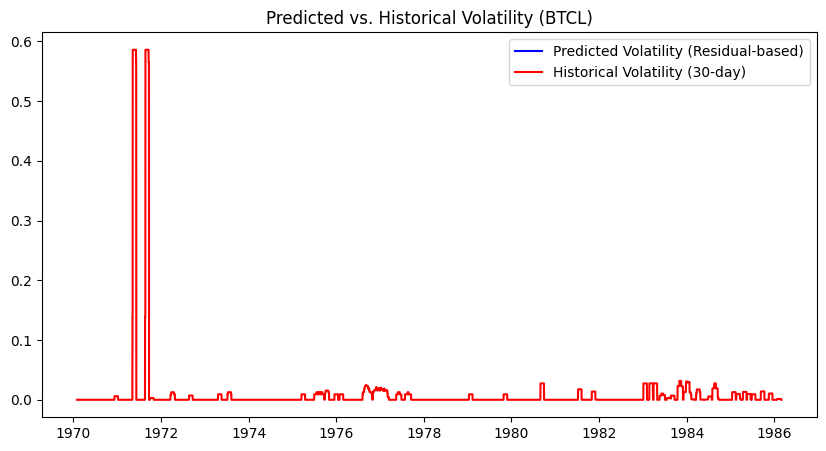

Value-at-Risk (95%): 0.0000
Conditional VaR (95%): -0.0829
Expected maximum daily loss (VaR, 95%): Nu. 0.00
Expected average loss beyond VaR (CVaR, 95%): Nu. -8287.71


In [8]:
# --- Section: Risk Management Implications ---

# Load future actual prices
future_actuals = pd.read_csv("/Users/ugyen/Documents/GitHub/Stockex-btn/Ensemble/BTCL_future_actual_cleaned.csv")
future_actuals['Date'] = pd.to_datetime(future_actuals['Date'])
future_actuals = future_actuals.set_index('Date').sort_index()

# Ensure we only take dates overlapping with ensemble forecast
aligned_actual = future_actuals.reindex(ensemble.index)['Close Price'].dropna()
aligned_forecast = ensemble.reindex(aligned_actual.index)

# Compute daily returns on historical series
df["Returns"] = df["BTCL"].pct_change()

# Rolling volatility (historical, 30-day window)
df["RollingVol"] = df["Returns"].rolling(window=30).std()

# Predicted volatility: rolling std of forecast residuals
forecast_residuals = aligned_actual.values - aligned_forecast['Ensemble'].values
pred_vol = pd.Series(forecast_residuals, index=aligned_forecast.index).rolling(30).std()

# Plot actual vs predicted volatility
plt.figure(figsize=(10,5))
plt.plot(pred_vol.index, pred_vol, label="Predicted Volatility (Residual-based)", color='blue')
plt.plot(df['RollingVol'].index, df['RollingVol'], label="Historical Volatility (30-day)", color='red')
plt.legend()
plt.title("Predicted vs. Historical Volatility (BTCL)")
plt.show()

# --- Value-at-Risk (VaR) and Conditional VaR (CVaR) ---

# Use historical returns for VaR/CVaR
confidence = 0.95
VaR = np.percentile(df["Returns"].dropna(), (1-confidence)*100)
CVaR = df["Returns"][df["Returns"] < VaR].mean()

print(f"Value-at-Risk (95%): {VaR:.4f}")
print(f"Conditional VaR (95%): {CVaR:.4f}")

# --- Portfolio Risk Example ---
investment = 100000  # Nu. 100,000 invested in BTCL
potential_loss_VaR = investment * VaR
potential_loss_CVaR = investment * CVaR

print(f"Expected maximum daily loss (VaR, 95%): Nu. {potential_loss_VaR:.2f}")
print(f"Expected average loss beyond VaR (CVaR, 95%): Nu. {potential_loss_CVaR:.2f}")
